In [1]:
from __future__ import division
from tfutils import base, data, optimizer, utils
import numpy as np
import tensorflow as tf
import os
import pymongo as pm
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib inline

In [2]:
class model_class:     
    def __init__(self, model = 'ln_model', trained_on = 'whitenoise'):
        self.model = model
        self.trained_on = trained_on
        
        # set up internal params
        self.dbname = model
        self.collname = trained_on
        exp_dict = {'ln_model': 'trainval0', 'cnn':'trainval1'}
        self.exp_id = exp_dict[model]
        self.title = '\nfor model %s trained on %s'%(model, trained_on)
        
        # now load our collection
        self.coll = self.load_coll()
        
        # check our train losses
        self.train_losses = self.get_losses()
        
        # get the last correlations
        self.white_corrs = self.get_validation_data(valname = 'white_noise_testcorr')
        self.natural_corrs = self.get_validation_data(valname = 'natural_scenes_testcorr')
    
    def load_coll(self):
        port = 24444
        conn = pm.MongoClient(port = port)
        coll = conn[self.dbname][self.collname + '.files']
        return coll
    
    def get_losses(self):
        """
        Gets all loss entries from the database and concatenates them into a vector
        """
        q_train = {'exp_id' : self.exp_id, 'train_results' : {'$exists' : True}}
        return np.array([_r['loss'] 
                         for r in self.coll.find(q_train, projection = ['train_results']) 
                         for _r in r['train_results']])

    def get_validation_data(self, valname):
        """
        Gets the validation data from the database (except for gridfs data)
        """
        q_val = {'exp_id' : self.exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
        val_steps = self.coll.find(q_val, projection = ['validation_results'])
        return [val_steps[i]['validation_results'][valname] 
                if valname in val_steps[i]['validation_results'].keys() else None
                for i in range(val_steps.count())]    
    
    def plot_train_losses(self):
        plt.plot(self.train_losses)
        plt.xlabel('train step')
        plt.ylabel('loss')
        plt.title('Training loss' + self.title)
    
    def plot_white_corr(self):
        corrs = [c['corr'][0] if c else [np.nan]*5 for c in self.white_corrs]
        corrs = np.array(corrs)
        plt.plot(corrs);
        plt.ylim(0, 1.0)
        plt.xlabel('val step')
        plt.ylabel('pearson corr')
        plt.title('White noise validation correlation' + self.title)
        
    def plot_natural_corr(self):
        corrs = [c['corr'][0] if c else [np.nan]*5 for c in self.natural_corrs]
        corrs = np.array(corrs)
        plt.plot(corrs);        
        plt.ylim(0, 1.0)
        plt.xlabel('val step')
        plt.ylabel('pearson corr')
        plt.title('Natural scenes validation correlation' + self.title)

    def say_last_natural_corr(self):
        print(self.title)
        print('Final step natural scene correlation for our 5 cells:')
        lastcorr = self.natural_corrs[-1]['corr']
        for icorr in lastcorr[0]:
            print '\t' + str(icorr)
            
    def say_last_white_corr(self):
        print(self.title)
        print('Final step white noise correlation for our 5 cells:')
        lastcorr = self.white_corrs[-1]['corr']
        for icorr in lastcorr[0]:
            print '\t' + str(icorr)            

In [3]:
model_name_list = ['ln_model','cnn']
trained_on_list = ['whitenoise', 'naturalscene']
model_dict = {}
for iname in model_name_list:
    for itrain in trained_on_list:
        model_dict[(iname, itrain)] = model_class(iname, itrain)

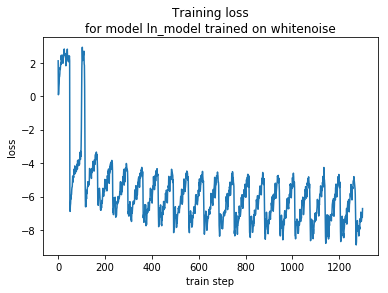

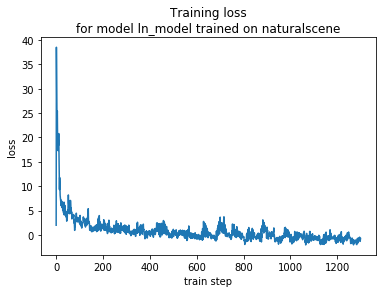

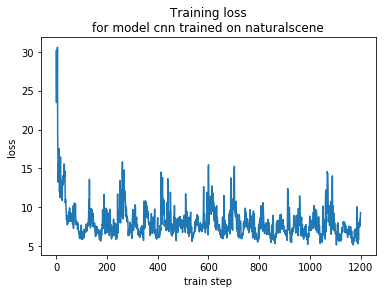

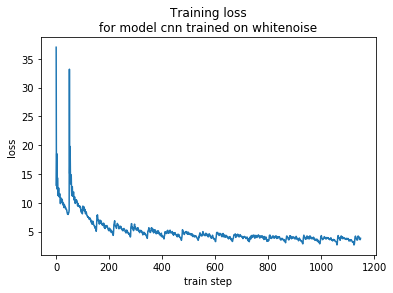

In [10]:
for imodel in model_dict.values():
    plt.figure()
    imodel.plot_train_losses()

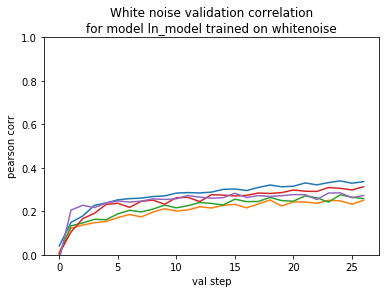

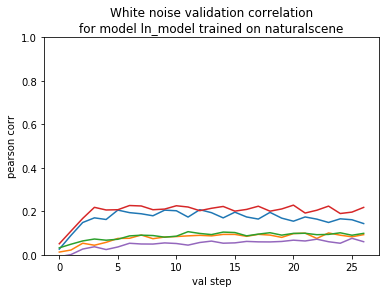

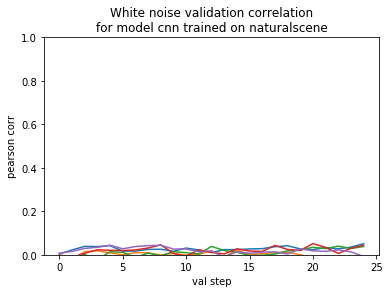

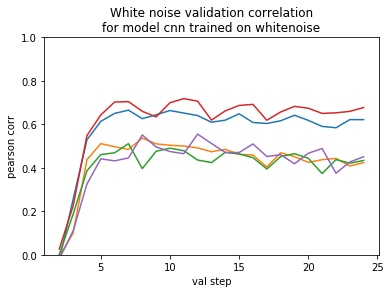

In [11]:
for imodel in model_dict.values():
    plt.figure()
    imodel.plot_white_corr()

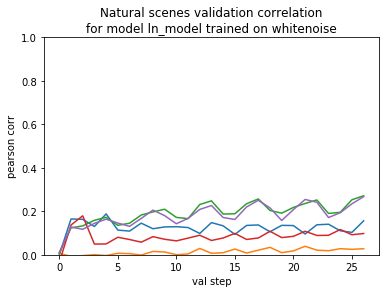

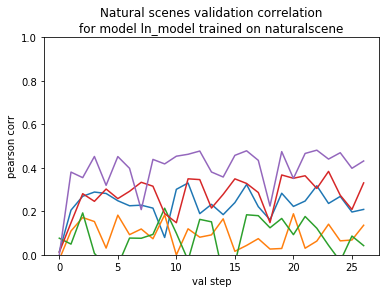

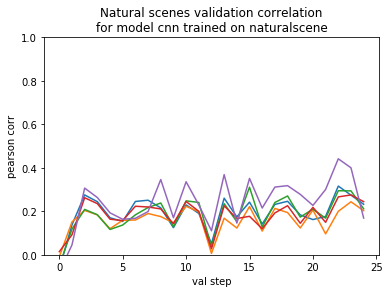

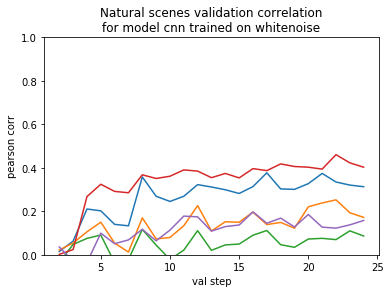

In [12]:
for imodel in model_dict.values():
    plt.figure()
    imodel.plot_natural_corr()

In [15]:
for imodel in model_dict.values():
    imodel.say_last_white_corr()


for model ln_model trained on whitenoise
Final step white noise correlation for our 5 cells:
	0.3363904953
	0.250640243292
	0.258282154799
	0.312845528126
	0.272637605667

for model ln_model trained on naturalscene
Final step white noise correlation for our 5 cells:
	0.143654942513
	0.092709004879
	0.0986092016101
	0.217975467443
	0.0602164193988

for model cnn trained on naturalscene
Final step white noise correlation for our 5 cells:
	0.0512722693384
	-0.0129644926637
	0.0381456315517
	0.0446212626994
	-0.00747248530388

for model cnn trained on whitenoise
Final step white noise correlation for our 5 cells:
	0.621570944786
	0.423909276724
	0.43383449316
	0.677228033543
	0.450954824686


In [16]:
for imodel in model_dict.values():
    imodel.say_last_natural_corr()


for model ln_model trained on whitenoise
Final step natural scene correlation for our 5 cells:
	0.156279295683
	0.0278517156839
	0.271454751492
	0.0979581549764
	0.267513394356

for model ln_model trained on naturalscene
Final step natural scene correlation for our 5 cells:
	0.208748817444
	0.135911673307
	0.0421778522432
	0.330654919147
	0.431473702192

for model cnn trained on naturalscene
Final step natural scene correlation for our 5 cells:
	0.232339411974
	0.202745720744
	0.211582094431
	0.244374930859
	0.169020488858

for model cnn trained on whitenoise
Final step natural scene correlation for our 5 cells:
	0.313112586737
	0.17203836143
	0.0864363238215
	0.402896881104
	0.157838255167
